In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import os, gzip, struct
rng = np.random.default_rng()

def _expected_zipf_trunc(alpha: float, k_min: int, k_max: int) -> float:
    ks = np.arange(k_min, k_max + 1)
    Z = np.sum(ks ** (-alpha))
    return np.sum(ks ** (1 - alpha)) / Z

def _choose_kmax_for_target_mean(n_rows: int, alpha: float, target_mean: float, k_min: int = 1) -> int:
    lo, hi = max(k_min, 1), n_rows
    for _ in range(30):  # binary search
        mid = (lo + hi) // 2
        mean = _expected_zipf_trunc(alpha, k_min, mid)
        if mean > target_mean:
            hi = mid
        else:
            lo = mid + 1
    return min(max(k_min, hi), n_rows)

def powerlaw_mask(n_rows: int,
                  n_cols: int,
                  density: float,
                  alpha: float = 2.3,
                  k_min: int = 1,
                  allow_self_loops: bool = True,
                  rng: np.random.Generator = None) -> np.ndarray:
    """
    Return a (n_rows x n_cols) 0/1 mask where each column's in-degree
    follows a truncated Zipf(alpha) with mean â‰ˆ density * n_rows.

    - n_rows: presynaptic count (rows)
    - n_cols: postsynaptic count (cols)
    - density: target mean in-degree as a fraction of n_rows (like your 'sparsity')
    - alpha: tail exponent (2â€“3 typical; lower => heavier tails)
    - k_min: minimum in-degree per column (avoid zero columns)
    - allow_self_loops: only relevant when n_rows == n_cols (recurrent case)
    """
    if rng is None:
        rng = np.random.default_rng()

    target_mean = max(1, int(round(density * n_rows)))
    k_max = _choose_kmax_for_target_mean(n_rows, alpha, target_mean, k_min=k_min)

    mask = np.zeros((n_rows, n_cols), dtype=bool)
    deg = rng.zipf(alpha, size=n_cols).astype(int)
    deg = np.clip(deg, k_min, k_max)

    for j, k in enumerate(deg):
        # Cap k to available rows if needed
        if not allow_self_loops and n_rows == n_cols:
            # sample without the diagonal index j
            k = min(k, n_rows - 1)
            choices = rng.choice(n_rows - 1, size=k, replace=False)
            rows = choices + (choices >= j)
        else:
            k = min(k, n_rows)
            rows = rng.choice(n_rows, size=k, replace=False)
        mask[rows, j] = True

    return mask.astype(float)  # 1.0 where connected, else 0.0

In [2]:
# Convert to CSV
SRC = "data/mnist"   # folder with the 4 .gz files
DST = "data/mnist"   # where CSVs will be written
os.makedirs(DST, exist_ok=True)

def read_idx_images(path):
    with gzip.open(path, 'rb') as f:
        magic, n, rows, cols = struct.unpack('>IIII', f.read(16))
        assert magic == 2051, f"bad magic for images: {magic}"
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(n, rows*cols)

def read_idx_labels(path):
    with gzip.open(path, 'rb') as f:
        magic, n = struct.unpack('>II', f.read(8))
        assert magic == 2049, f"bad magic for labels: {magic}"
        return np.frombuffer(f.read(), dtype=np.uint8)

Xtr = read_idx_images(os.path.join(SRC,'train-images-idx3-ubyte.gz'))
ytr = read_idx_labels(os.path.join(SRC,'train-labels-idx1-ubyte.gz'))
Xte = read_idx_images(os.path.join(SRC,'t10k-images-idx3-ubyte.gz'))
yte = read_idx_labels(os.path.join(SRC,'t10k-labels-idx1-ubyte.gz'))

np.savetxt(os.path.join(DST,'mnist_train.csv'), np.column_stack([ytr, Xtr]), fmt='%d', delimiter=',')
np.savetxt(os.path.join(DST,'mnist_test.csv'),  np.column_stack([yte, Xte]), fmt='%d', delimiter=',')
print("Wrote CSVs:", os.path.join(DST,'mnist_train.csv'), os.path.join(DST,'mnist_test.csv'))

Wrote CSVs: data/mnist\mnist_train.csv data/mnist\mnist_test.csv


In [3]:
#Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [4]:
train_imgs = train_data[:, 1:]
test_imgs = test_data[:, 1:]
train_labels = train_data[:, 0]
test_labels = test_data[:, 0]

In [5]:
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [6]:
n_in = 784
n_neurons = 2000
cap_size = 200
sparsity = 0.1
n_rounds = 5
beta = 1e0
mask = np.zeros((n_neurons, n_neurons), dtype=bool)
W = np.zeros((n_neurons, n_neurons))
mask_a = np.zeros((n_in, n_neurons), dtype=bool)
A = np.zeros((n_in, n_neurons))
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

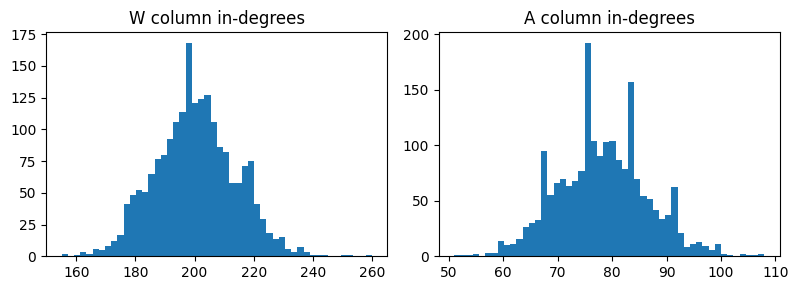

In [7]:
deg_W = mask.sum(axis=0)     # in-degree per postsynaptic neuron for W
deg_A = mask_a.sum(axis=0)   # in-degree for A

fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].hist(deg_W, bins=50)
ax[0].set_title('W column in-degrees')
ax[1].hist(deg_A, bins=50)
ax[1].set_title('A column in-degrees')
plt.tight_layout()


In [8]:
from scipy.signal import convolve
n_examples = 5000
examples = np.zeros((10, n_examples, 784))
for i in range(10):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

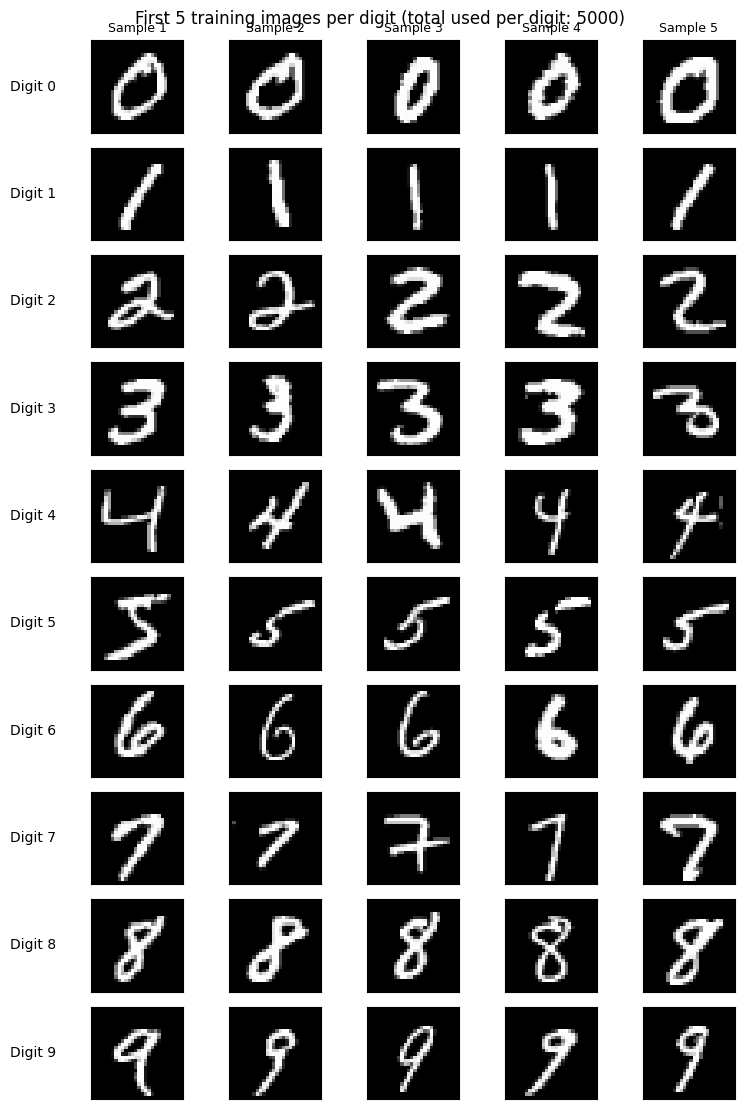

In [9]:
# Visualize a sample of training images (first 5 per digit)
samples_per_digit = 5
fig, axes = plt.subplots(10, samples_per_digit, figsize=(samples_per_digit * 1.6, 12), sharex=True, sharey=True)
for digit in range(10):
    digit_images = train_imgs[train_labels == digit][:samples_per_digit]
    for j in range(samples_per_digit):
        ax = axes[digit, j] if samples_per_digit > 1 else axes[digit]
        ax.imshow(digit_images[j].reshape(28, 28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        if digit == 0:
            ax.set_title(f'Sample {j + 1}', fontsize=9)
        if j == 0:
            ax.set_ylabel(f'Digit {digit}', rotation=0, labelpad=25, va='center', ha='right')

plt.suptitle(f'First {samples_per_digit} training images per digit (total used per digit: {n_examples})', y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [10]:
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
W /= W.sum(axis=0, keepdims=True)
A /= A.sum(axis=0, keepdims=True)
bias = np.zeros(n_neurons)
b = -1
activations = np.zeros((10, n_rounds, n_neurons))
for i in range(10):
    act_h = np.zeros(n_neurons)
    for j in range(n_rounds):
        input = examples[i, j]
        act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
        activations[i, j] = act_h_new.copy()
        A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        act_h = act_h_new
    bias[act_h > 0] += b
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=0, keepdims=True)

In [11]:
outputs = np.zeros((10, n_rounds+1, n_examples, n_neurons))
for i in np.arange(10):
    for j in range(n_rounds):
        outputs[i, j+1] = k_cap(outputs[i, j] @ W + examples[i] @ A, cap_size)

In [12]:
idx = np.full(n_neurons, -1, dtype=int)
# act = outputs[:, -1].sum(axis=1)
act = activations[:, -1].copy()
for i, j in enumerate(range(10)):
    idx[i*cap_size:(i+1)*cap_size] = act[j].argsort()[-cap_size:][::-1]
    act[:, idx[i*cap_size:(i+1)*cap_size]] = -1
r = np.arange(n_neurons)
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size:] = np.unique(r)[1:]

Text(0.04, 0.5, 'Samples')

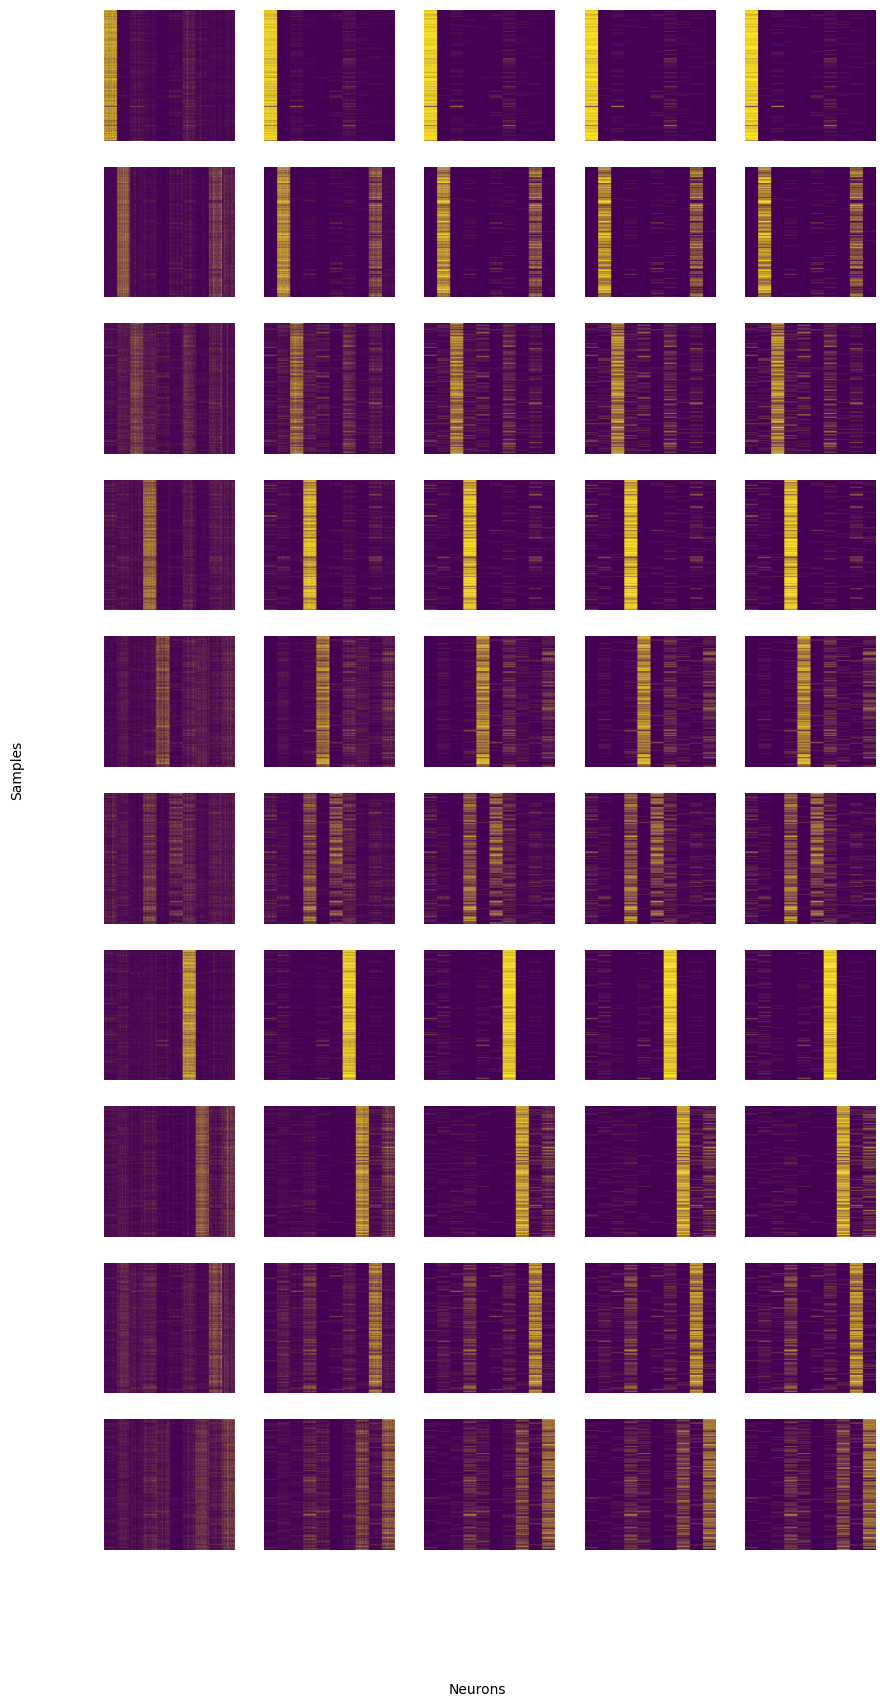

In [13]:
fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

In [14]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

In [15]:
v = 0.1 * rng.standard_normal((10, n_neurons))
targets = np.zeros((100, 10))
for i in range(10):
    targets[i*10:(i+1)*10, i] = 1
update = np.zeros_like(v)

In [16]:
for _ in range(100):
    permutation = rng.permutation(n_examples - 1000)
    for j in range((n_examples - 1000) // 10):
        batch = outputs[:, 1, permutation[j*10:(j+1)*10]].reshape(10 * 10, n_neurons)
        scores = softmax((batch[:, :, np.newaxis] * v.T[np.newaxis, :, :]).sum(axis=1))
        update = 0.5 * update + 1e-3 * (batch[:, np.newaxis, :] * (scores - targets)[:, :, np.newaxis]).sum(axis=0)
        v -= update
#             v = v.clip(min=0.0, max=1.0)
#             v[v < 1e-5] = 0.

In [17]:
((outputs[:, 1, :-1000] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 40000

np.float64(0.9988)

In [18]:
((outputs[:, 1, -1000:] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 10000

np.float64(0.9245)

In [19]:
c = np.zeros((10, n_neurons))
for i in range(10):
    c[i, outputs[i, 1].sum(axis=0).argsort()[-cap_size:]] = 1
#     c[i, idx[i*cap_size:(i+1)*cap_size]] = 1
predictions = (outputs[:, 1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples

In [20]:
acc

array([0.9166, 0.9456, 0.6784, 0.7866, 0.6728, 0.391 , 0.837 , 0.7692,
       0.5692, 0.627 ])

In [26]:
# Prepare test inputs and evaluation schedule
max_test_rounds = 10  # number of recurrent steps to evaluate
n_test_eval = 500     # number of test samples per digit to evaluate


In [27]:

kernel = np.ones((1, 3, 3))

test_examples = np.zeros((10, n_test_eval, 784))
for digit in range(10):
    digit_images = test_imgs[test_labels == digit][:n_test_eval]
    conv_imgs = convolve(digit_images.reshape(-1, 28, 28), kernel, mode='same')
    test_examples[digit] = k_cap(conv_imgs.reshape(-1, 28 * 28), cap_size)

In [28]:
# Run recurrent inference on the test set for multiple time budgets
avg_activation_snapshots = np.zeros((max_test_rounds, 10, n_neurons))
digit_acc_over_time = np.zeros((10, max_test_rounds))
overall_acc_over_time = np.zeros(max_test_rounds)

for digit in range(10):
    state = np.zeros((n_test_eval, n_neurons))
    inputs = test_examples[digit]
    for t in range(max_test_rounds):
        state = k_cap(state @ W + inputs @ A, cap_size)
        avg_activation_snapshots[t, digit] = state.mean(axis=0)
        scores = state @ c.T
        preds = scores.argmax(axis=1)
        digit_acc_over_time[digit, t] = (preds == digit).mean()

overall_acc_over_time = digit_acc_over_time.mean(axis=0)

overall_acc_over_time

array([0.699 , 0.6038, 0.5882, 0.5838, 0.5808, 0.5816, 0.582 , 0.5822,
       0.5822, 0.5824])

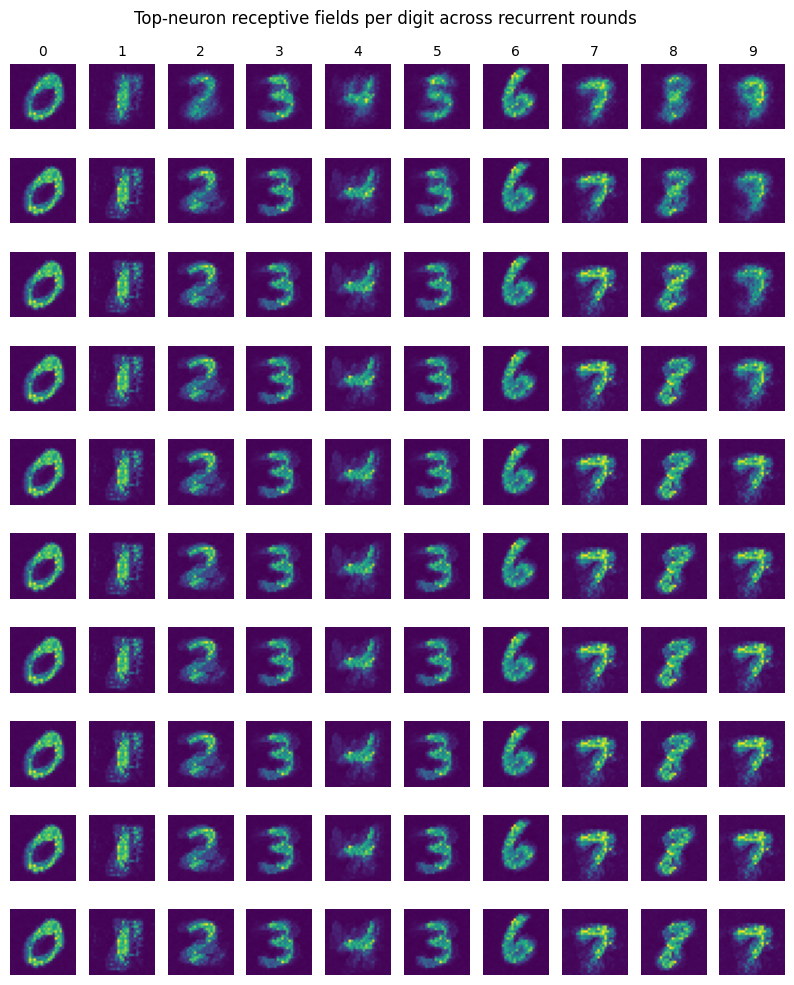

In [29]:
# Visualize the dominant receptive fields per digit across time budgets
fig, axes = plt.subplots(max_test_rounds, 10, figsize=(10, max_test_rounds * 1.2), sharex=True, sharey=True)

if max_test_rounds == 1:
    axes = axes[np.newaxis, :]

for t in range(max_test_rounds):
    for digit in range(10):
        ax = axes[t, digit]
        top_idx = avg_activation_snapshots[t, digit].argsort()[-cap_size:]
        mask = np.zeros(n_neurons)
        mask[top_idx] = 1.0
        receptive_field = (A * mask[np.newaxis, :]).sum(axis=1).reshape(28, 28)
        ax.imshow(receptive_field)
        ax.set_axis_off()
        if t == 0:
            ax.set_title(str(digit), fontsize=10)
        if digit == 0:
            ax.set_ylabel(f"t={t+1}", rotation=0, labelpad=25, va='center', ha='right', fontsize=10)

fig.suptitle('Top-neuron receptive fields per digit across recurrent rounds', y=0.92)
plt.show()

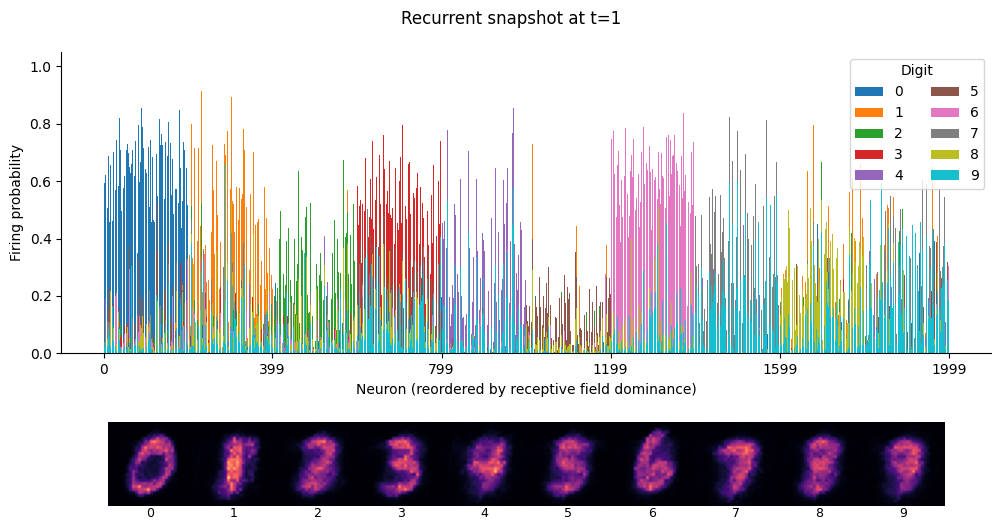

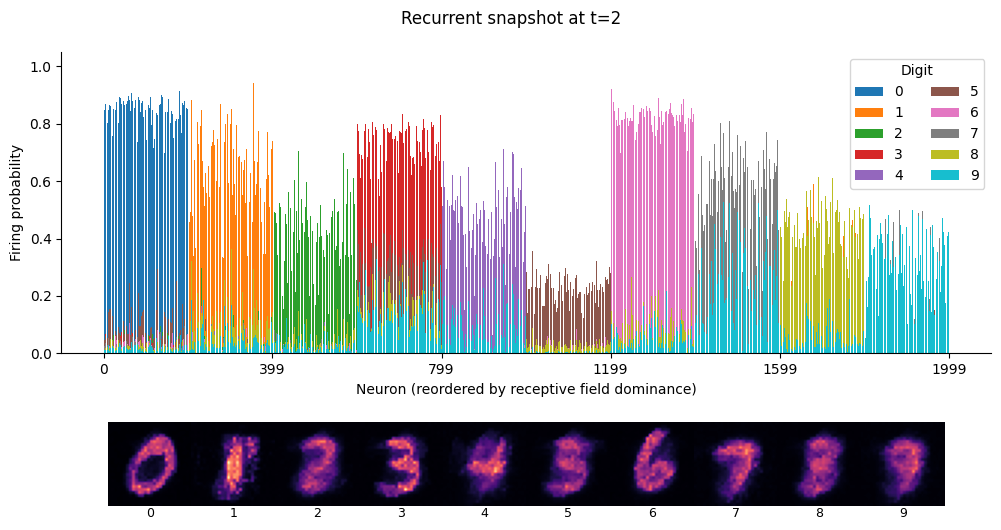

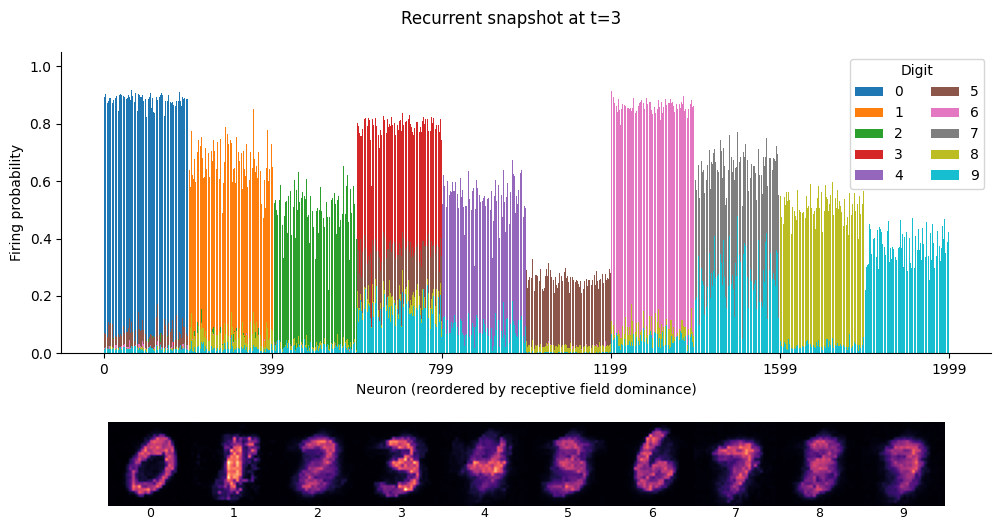

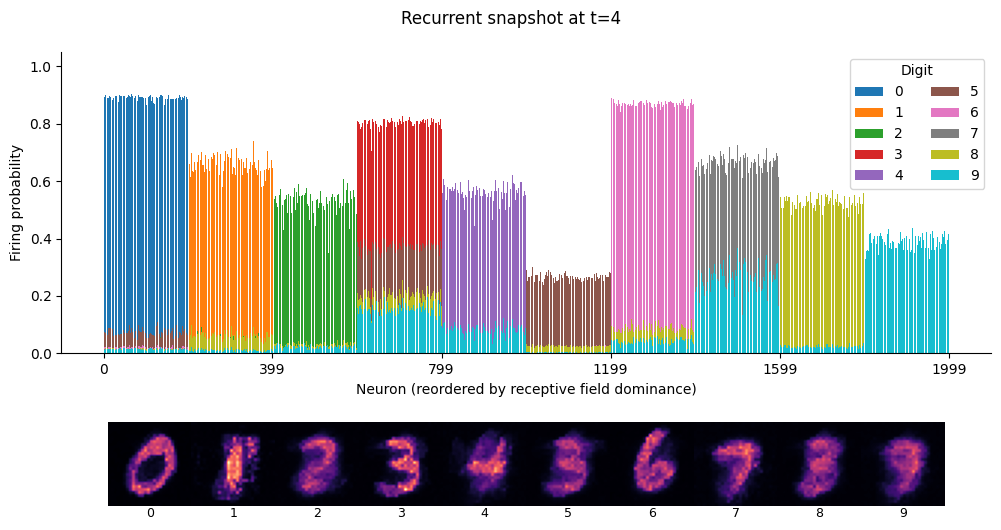

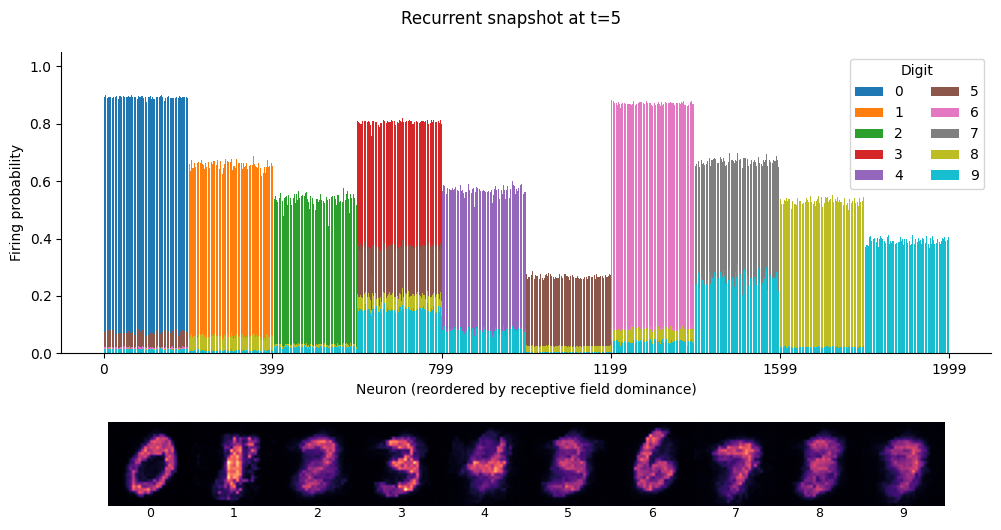

In [35]:
# Combined visualization of receptive fields (bottom) and firing probabilities (top)
n_time_steps = min(max_test_rounds, outputs.shape[1] - 1)
activation_templates = np.zeros((n_time_steps, 10, 28, 28))
for t_idx in range(n_time_steps):
    for digit in range(10):
        activation = avg_activation_snapshots[t_idx, digit]
        activation_templates[t_idx, digit] = (
            (A * activation[np.newaxis, :]).sum(axis=1).reshape(28, 28)
        )

template_min = activation_templates.min()
template_max = activation_templates.max()

for t in range(1, n_time_steps + 1):
    fig = plt.figure(figsize=(12, 6))
    outer = fig.add_gridspec(2, 1, height_ratios=[1.8, 0.6], hspace=0.3)

    ax_bar = fig.add_subplot(outer[0, 0])
    neuron_positions = np.arange(n_neurons)
    for digit in range(10):
        ax_bar.bar(
            neuron_positions,
            outputs[digit, t].mean(axis=0)[idx],
            label=digit,
        )

    ax_bar.set_ylim(0, 1.05)
    ax_bar.set_xlabel('Neuron (reordered by receptive field dominance)')
    ax_bar.set_ylabel('Firing probability')
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.set_xticks(np.linspace(0, n_neurons - 1, 6, dtype=int))
    ax_bar.legend(loc='upper right', ncol=2, title='Digit')

    img_grid = outer[1].subgridspec(1, 10, wspace=0.05)
    axes_imgs = []
    for digit in range(10):
        ax_img = fig.add_subplot(img_grid[0, digit])
        ax_img.imshow(
            activation_templates[t - 1, digit],
            cmap='magma',
            vmin=template_min,
            vmax=template_max,
        )
        ax_img.set_xticks([])
        ax_img.set_yticks([])
        ax_img.spines[:].set_visible(False)
        axes_imgs.append(ax_img)

    bar_pos = ax_bar.get_position()
    strip_pos = axes_imgs[0].get_position()

    N = 10
    cluster_frac = 0.9
    gap = 0.0

    total_w = bar_pos.width
    cluster_w = total_w * cluster_frac
    left_start = bar_pos.x0 + (total_w - cluster_w) / 2.0
    tile_w = (cluster_w - gap * (N - 1)) / N
    y0 = strip_pos.y0
    h  = strip_pos.height

    for i, ax_img in enumerate(axes_imgs):
        x = left_start + i * (tile_w + gap)
        ax_img.set_position([x, y0, tile_w, h])
        ax_img.set_xlabel(str(i), fontsize=9, labelpad=1)
        ax_img.xaxis.set_label_position('bottom')

    fig.suptitle(f'Recurrent snapshot at t={t}', y=0.95)
    plt.show()


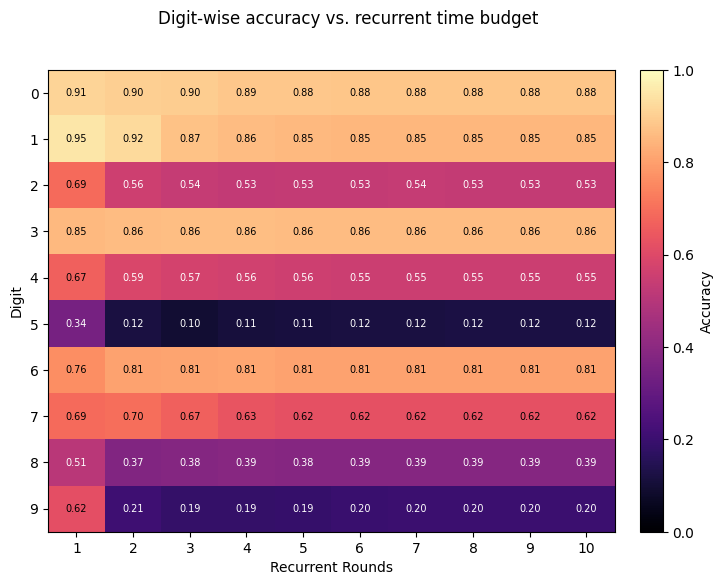

array([0.699 , 0.6038, 0.5882, 0.5838, 0.5808, 0.5816, 0.582 , 0.5822,
       0.5822, 0.5824])

In [31]:
# Accuracy per digit over time as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heat = ax.imshow(digit_acc_over_time, aspect='auto', cmap='magma', vmin=0.0, vmax=1.0)

ax.set_xlabel('Recurrent Rounds')
ax.set_ylabel('Digit')
ax.set_xticks(np.arange(max_test_rounds))
ax.set_xticklabels(np.arange(1, max_test_rounds + 1))
ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.arange(10))

for digit in range(10):
    for t in range(max_test_rounds):
        ax.text(t, digit, f"{digit_acc_over_time[digit, t]:.2f}",
                ha='center', va='center', color='white' if digit_acc_over_time[digit, t] < 0.6 else 'black', fontsize=7)

fig.colorbar(heat, ax=ax, fraction=0.046, pad=0.04, label='Accuracy')
fig.suptitle('Digit-wise accuracy vs. recurrent time budget')
plt.show()

overall_acc_over_time

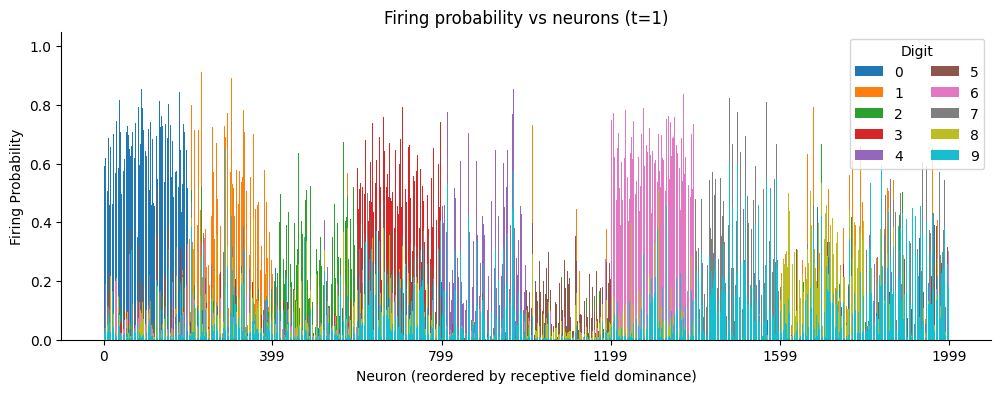

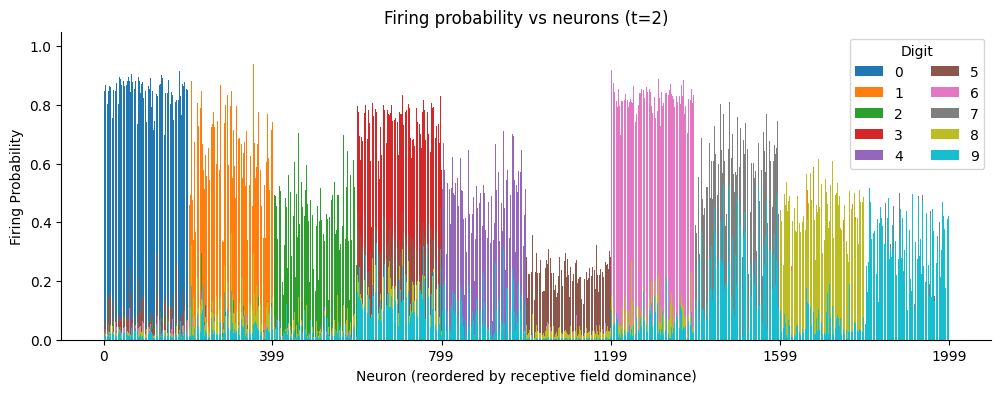

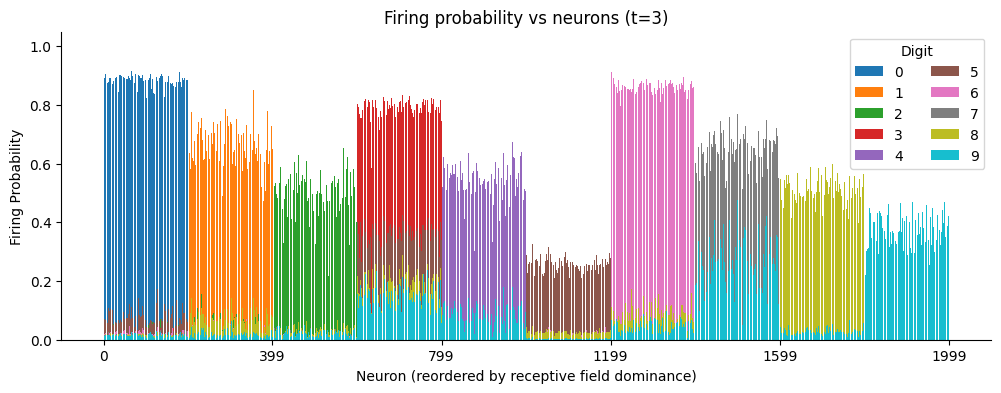

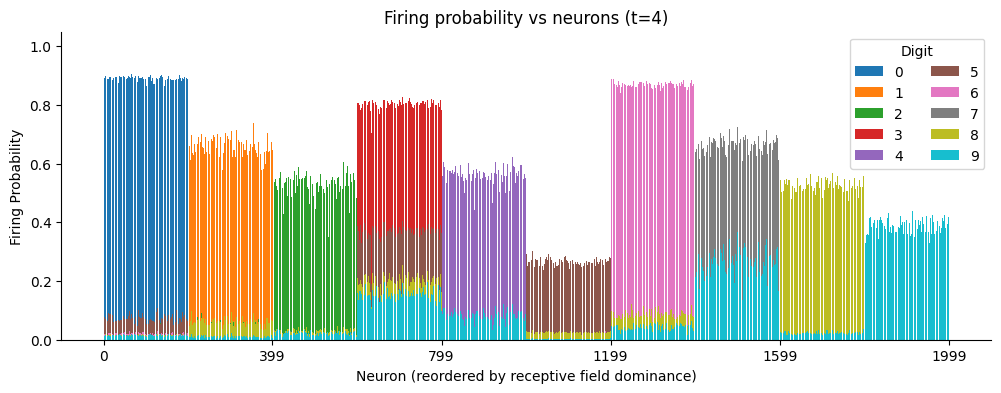

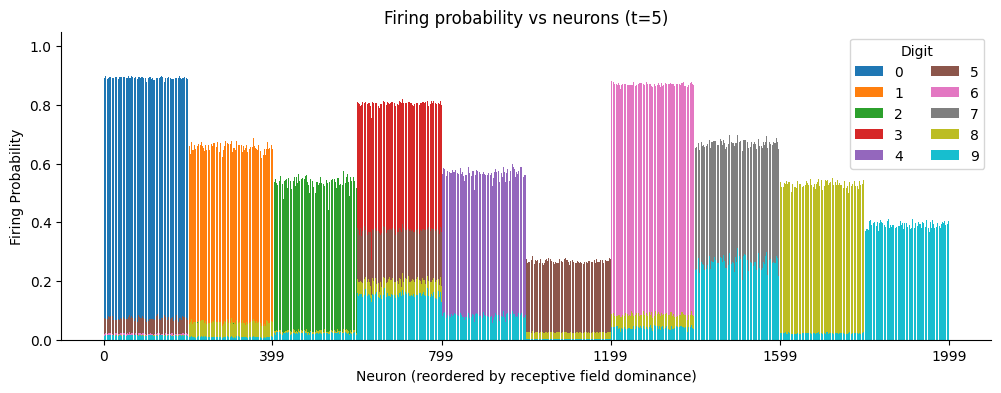

In [32]:
# Firing probability vs neurons for each time step
neuron_positions = np.arange(n_neurons)
n_time_steps = min(max_test_rounds, outputs.shape[1] - 1)
for t in range(1, n_time_steps + 1):
    fig = plt.figure(figsize=(12, 4))
    ax_bar = fig.add_subplot(1, 1, 1)
    for digit in range(10):
        ax_bar.bar(
            neuron_positions,
            outputs[digit, t].mean(axis=0)[idx],
            label=digit,
        )

    ax_bar.set_ylim(0, 1.05)
    ax_bar.set_title(f'Firing probability vs neurons (t={t})')
    ax_bar.set_xlabel('Neuron (reordered by receptive field dominance)')
    ax_bar.set_ylabel('Firing Probability')
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.set_xticks(np.linspace(0, n_neurons - 1, 6, dtype=int))
    ax_bar.legend(loc='upper right', ncol=2, title='Digit')
    plt.show()
